In [62]:
#Import necessary modules and data
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
import math
import netCDF4
import xarray as xr
import numpy as np
import nc_time_axis
import cartopy
import cartopy.crs as ccrs
from scipy import stats
from scipy.stats import norm
import scipy
import random
import sympy
import statistics
from importlib.metadata import version

print(version('xarray'))
#from sympy import symbols, solve
%matplotlib inline
plt.rcParams['text.usetex'] = True

fp6040 = '../a/DATA_held_suarez_20years_60K40days.nc'
ds6040 = xr.open_dataset(fp6040)
fp8040 = '../a/DATA_held_suarez_20years_80K40days.nc'
ds8040 = xr.open_dataset(fp8040)
fp4040 = '../a/DATA_held_suarez_20years_40K40days.nc'
ds4040 = xr.open_dataset(fp4040)
fp6014 = '../a/DATA_held_suarez_20years_60K14days.nc'
ds6014 = xr.open_dataset(fp6014)
fp2040 = '../a/DATA_held_suarez_20years_20K40days.nc'
ds2040 = xr.open_dataset(fp2040)

2022.11.0


In [2]:
###########FUNCTION Find the nearest value#################
def find_nearest(array, value):
    difference = []
    for i in array:
        difference.append(np.abs(i - value))
    the_one = min(difference)
    j = difference.index(the_one)
    the_value = array[j]
    return j, the_value

In [3]:
######################FUNCTION find derivative#################################
def take_derivative(arrayx, arrayy):
    deriv = []
    first_deriv = (arrayy[1]-arrayy[0])/(arrayx[1]-arrayx[0])
    deriv.append(first_deriv)
    for i in range(1,len(arrayx)-1):
        the_derivative = (arrayy[i+1]-arrayy[i-1])/(arrayx[i+1]-arrayx[i-1])
        deriv.append(the_derivative)
    last_deriv = (arrayy[-1]-arrayy[-2])/(arrayx[-1]-arrayx[-2])
    deriv.append(last_deriv)
    return deriv

In [4]:
######################FUNCTION make arrays for a visual Gaussian fit######################
def Gaussian_fit(array_x,array_y):
    #Create a set of data that follows distribution function f_Tphi_times_dTdphi.
    factor = 500/max(array_y)
    new_data = []
    for i in range(0,len(array_y)-1):
        number = int(array_y[i]*factor)
        for j in range(0, number-1):
            new_data.append(array_x[i])        
    
    new_data_df = pd.DataFrame(new_data)
    
    meanL, stdL = norm.fit(new_data_df)
    xL = np.arange(meanL-5*stdL, meanL+5*stdL, 0.001)
    yL = stats.norm.pdf(xL, meanL, stdL)
    
    return xL, yL


In [5]:
######################FUNCTION normalize##########################
def normalize(array_x,array_y):
    total_area = 0
    for i in range(0,len(array_x)-1):
        area = array_y[i]*np.abs(array_x[i+1]-array_x[i])
        total_area = total_area + area
    new_array = array_y/total_area
    return new_array

In [6]:
##############FUNCTION Pick locations#####################
def pick_location(lat, lon, pressure):
    #Find the latitude, pressude and longitude values to use
    lat_index, latitude = find_nearest(T6040.lat,lat)
    pp_index, pp = find_nearest(T6040.pfull,pressure)
    lon_index, longitude = find_nearest(T6040.lon,lon)
    if lon ==1000:
        lon_index = 1000
    else:
        pass
    return lat_index, latitude, pp_index, pp, lon_index, longitude

In [7]:
#Useful temperature arrays to use for the rest of this code
T6040 = ds6040.temp.sel(time = slice('1812-04','1826'))
T_ave6040 = T6040.mean(dim = 'time')

#T8040 = ds8040.temp.sel(time = slice('1812-04','1826'))
#T_ave8040 = T8040.mean(dim = 'time')
T4040 = ds4040.temp.sel(time = slice('1812-04','1826'))
T_ave4040 = T4040.mean(dim = 'time')

T2040 = ds2040.temp.sel(time = slice('1812-04','1826'))
T_ave2040 = T2040.mean(dim = 'time')

T6014 = ds6014.temp.sel(time = slice('1812-04','1826'))
T_ave6014 = T6014.mean(dim = 'time')

start_i = int(len(T6040.lat.values)/2)
end_i = int(len(T6040.lat.values))
lat_half = T6040.lat.isel(lat = slice(start_i,end_i))

## For average, skip from here (except for functions.... haha)

In [13]:
#Decide the location( 0 gives a good one)

lat_index, latitude, pp_index, pp, lon_index, longitude = pick_location(67,0,850)
if lon_index == 1000:
    pass
else:
    T_ave_profile6040 = T_ave6040.isel(lon = lon_index, pfull = pp_index).values
    T_ave_profile4040 = T_ave4040.isel(lon = lon_index, pfull = pp_index).values
    T_ave_profile2040 = T_ave2040.isel(lon = lon_index, pfull = pp_index).values
    T_ave_profile6014 = T_ave6014.isel(lon = lon_index, pfull = pp_index).values
    
T_lon_ave6040 = T6040.isel(pfull = pp_index).mean(dim = 'lon')
T_lon_time_ave6040 = T_lon_ave6040.mean(dim = 'time').values
T_lon_ave4040 = T4040.isel(pfull = pp_index).mean(dim = 'lon')
T_lon_time_ave4040 = T_lon_ave4040.mean(dim = 'time').values
T_lon_ave2040 = T2040.isel(pfull = pp_index).mean(dim = 'lon')
T_lon_time_ave2040 = T_lon_ave2040.mean(dim = 'time').values
T_lon_ave6014 = T6014.isel(pfull = pp_index).mean(dim = 'lon')
T_lon_time_ave6014 = T_lon_ave6014.mean(dim = 'time').values


print('longitude = ' + str(longitude.values) + ' degrees, lon_index = ' + str(lon_index))

longitude = 0.0 degrees, lon_index = 0


In [14]:
#Put the data in an array for convenience (decreasing order in temperature, then change in tau)
#number index: 0 = 6040, 1 = 4040, 2 = 2040, 3 = 6014
T_lon_ave = [T_lon_ave6040, T_lon_ave4040, T_lon_ave2040, T_lon_ave6014] #Lon average, pfull is set. Has data for different times
T_ave_profile = [T_ave_profile6040, T_ave_profile4040, T_ave_profile2040, T_ave_profile6014] #Time average, lon and pfull are set
T_lon_time_ave = [T_lon_time_ave6040, T_lon_time_ave4040, T_lon_time_ave2040, T_lon_time_ave6014] #Lon and time average, pfull is set
T_original = [T6040, T4040, T2040, T6014] #Original T - not even pful is set

In [19]:
##Derivatives

#Phi and original T
Phi_half = np.linspace(0,90,1000)

#Interpolate T
T_profile = []
for i in range(0, len(T_lon_ave)):
    if lon_index == 1000:
        T_interpolate = scipy.interpolate.pchip_interpolate(T6040.lat.values, T_lon_time_ave[i], Phi_half)
    else:
        T_interpolate = scipy.interpolate.pchip_interpolate(T6040.lat.values, T_ave_profile[i], Phi_half)
    T_profile.append(T_interpolate)

#Calculate derivatives 
dTdphi = []
d2Tdphi2 = []
d3Tdphi3 = []
d4Tdphi4 = []
d5Tdphi5 = []
d6Tdphi6 = []
for i in range(0, len(T_lon_ave)):
    dTdphi1 = take_derivative(Phi_half, T_profile[i])
    dTdphi1 = scipy.signal.savgol_filter(dTdphi1,150,1)
    dTdphi.append(dTdphi1)
    dTdphi2 = take_derivative(Phi_half, dTdphi1)
    dTdphi2 = scipy.signal.savgol_filter(dTdphi2,150,1)
    d2Tdphi2.append(dTdphi2)
    dTdphi3 = take_derivative(Phi_half, dTdphi2)
    dTdphi3 = scipy.signal.savgol_filter(dTdphi3,150,1)
    d3Tdphi3.append(dTdphi3)
    dTdphi4 = take_derivative(Phi_half, dTdphi3)
    dTdphi4 = scipy.signal.savgol_filter(dTdphi4,150,1)
    d4Tdphi4.append(dTdphi4)
    dTdphi5 = take_derivative(Phi_half, dTdphi4)
    dTdphi5 = scipy.signal.savgol_filter(dTdphi5,150,1)
    d5Tdphi5.append(dTdphi5)
    dTdphi6 = take_derivative(Phi_half, dTdphi5)
    dTdphi6 = scipy.signal.savgol_filter(dTdphi6,150,1)
    d6Tdphi6.append(dTdphi6)

In [20]:
#Recreate T_RCE
DeltaT = [60,40,20,60]
p = pp.values
p0 = 1000
kappa = 2/7
T_RCE = []
for i in DeltaT:
    T_RCE_one = []
    for j in Phi_half:
        the_value = (315 - i*(np.sin(np.radians(j)))**2-10*np.log(p/p0)*(np.cos(np.radians(j)))**2)*(p/p0)**kappa
        T_RCE_one.append(the_value)
    T_RCE.append(T_RCE_one)


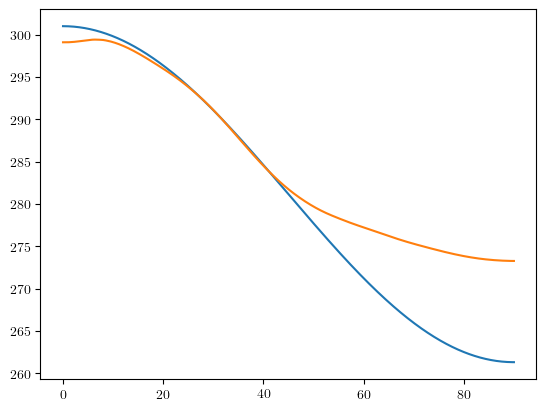

In [21]:
plt.plot(Phi_half,T_RCE[1])
plt.plot(Phi_half, T_profile[1])

In [22]:
#Now derivatives of T_RCE
dTdphiRCE = []
for i in DeltaT:
    dTdphiRCE_almost =[]
    for j in Phi_half:
        dTdphiRCE_one = ((p/p0)**kappa)*(-2*i+20*np.log(p/p0))*np.sin(np.radians(j))*np.cos(np.radians(j))
        dTdphiRCE_almost.append(dTdphiRCE_one)
    dTdphiRCE.append(dTdphiRCE_almost)

# #Calculate derivatives 
# dTdphiRCE = []
# d2Tdphi2RCE = []
# d3Tdphi3RCE = []
# d4Tdphi4RCE = []
# d5Tdphi5RCE = []
# d6Tdphi6RCE = []

# for i in range(0, len(T_RCE)):
#     dTdphi1RCE = take_derivative(Phi_half, T_RCE[i])
#     dTdphi1RCE = scipy.signal.savgol_filter(dTdphi1RCE,150,1)
#     dTdphiRCE.append(dTdphi1RCE)
#     dTdphi2RCE = take_derivative(Phi_half, dTdphi1RCE)
#     dTdphi2RCE = scipy.signal.savgol_filter(dTdphi2RCE,150,1)
#     d2Tdphi2RCE.append(dTdphi2RCE)
#     dTdphi3RCE = take_derivative(Phi_half, dTdphi2RCE)
#     dTdphi3RCE = scipy.signal.savgol_filter(dTdphi3RCE,150,1)
#     d3Tdphi3RCE.append(dTdphi3RCE)
#     dTdphi4RCE = take_derivative(Phi_half, dTdphi3RCE)
#     dTdphi4RCE = scipy.signal.savgol_filter(dTdphi4RCE,150,1)
#     d4Tdphi4RCE.append(dTdphi4RCE)
#     dTdphi5RCE = take_derivative(Phi_half, dTdphi4RCE)
#     dTdphi5RCE = scipy.signal.savgol_filter(dTdphi5RCE,150,1)
#     d5Tdphi5RCE.append(dTdphi5RCE)
#     dTdphi6RCE = take_derivative(Phi_half, dTdphi5RCE)
#     dTdphi6RCE = scipy.signal.savgol_filter(dTdphi6RCE,150,1)
#     d6Tdphi6RCE.append(dTdphi6RCE)

## Number index:

0 = 6040 

1 = 4040

2 = 2040

3 = 6014

## Names of data:

Temperature at various p-level, latitude, longitude, and time = T_original (lat size = 128, +/-)

Temperature at various latitude and time, averaged over longitude = T_lon_ave (lat size = 128, +/-)

Same as above, but time average = T_lon_time_ave

Temperature at various latitude, pfull is set, time average = T_profile (lat size = 128, +/-)


Time-averaged temperature profile [the reference T] = T_profile (lat size 1000, + only, uses average if lon_index = 1000)


In [23]:
####### FUNCTION Calculate sigma_T #######
def calculate_sigma_T_data(number):

    std_data = []
    
    if lon_index == 1000:
        for i in range(start_i,end_i):    
            T_vs_lat = T_lon_ave[number].isel(lat = i)
            stdT = scipy.stats.tstd(T_vs_lat)
            std_data.append(stdT)
    else:
        for i in range(start_i,end_i): 
            T_vs_lat = T_original[number].isel(pfull = pp_index, lon = lon_index, lat = i)
            stdT = scipy.stats.tstd(T_vs_lat)
            std_data.append(stdT)
            
    std_data = scipy.interpolate.pchip_interpolate(lat_half, std_data, Phi_half)
    return std_data

In [24]:
#Calculate sigma T here
std4040_data = calculate_sigma_T_data(1)
std6040_data = calculate_sigma_T_data(0)
std2040_data = calculate_sigma_T_data(2)
std6014_data = calculate_sigma_T_data(3)
sigma_T = [std6040_data, std4040_data, std2040_data, std6014_data]

In [25]:
#####FUNCTION Calculate sigma_phi from data directly#####

def calculate_sigma_phi_data_single(lat_i, lon_i, number): 

    if lon_i == 1000:
        distribution = T_lon_ave[number].isel(lat = lat_i).values
    else:
        distribution = T_original[number].isel(pfull = pp_index, lat = lat_i, lon = lon_i).values


    Lat = []
    for j in distribution:
        index, value = find_nearest(T_profile[number],j)
        Lat.append(1*Phi_half[index])

    std_phi = scipy.stats.tstd(Lat)

    print(std_phi)
    
    return std_phi

In [26]:
####### FUNCTION Calculate sigma_phi_data at all latitudes #######
def calculate_sigma_phi_data(lon_i, number):
    sigma_phi_data = []
    for i in range(start_i,end_i):
        value = calculate_sigma_phi_data_single(i, lon_i, number)
        sigma_phi_data.append(value)
    sigma_phi_data= scipy.interpolate.pchip_interpolate(lat_half,sigma_phi_data, Phi_half)
    return sigma_phi_data

## Fit data using standard deviation

In [27]:
#Make a function that gives my estimate from derivatives

#Find the max location first 
epsilon = 10
sigma_phi = []
for j in range(0, len(T_lon_ave)):
    index = np.where(sigma_T[j] == max(sigma_T[j]))[0][0]
    domain1 = index-epsilon
    domain2 = index+epsilon
    def f_sigma(phi, sigma):
        std1 = []
    #    for i in range(0,len(Phi_half)):
        for i in range(domain1,domain2):
            variance = dTdphi[j][i]**2 * sigma **2
            std1.append(np.sqrt(variance))
        return std1

    #Fit!
    fit_values, sigma_cov = scipy.optimize.curve_fit(f_sigma, Phi_half[domain1:domain2], sigma_T[j][domain1:domain2])
    sigma_phi.append(fit_values[0])

print(sigma_phi)

[6.951913980519658, 6.218802192372688, 5.870021236798763, 6.855142389680059]


In [28]:
#Do the same with T_RCE
#Make a function that gives my estimate from derivatives

#Find the max location first 
epsilon = 10
sigma_phiRCE = []
for j in range(0, len(T_lon_ave)):
    index = np.where(sigma_T[j] == max(sigma_T[j]))[0][0]
    domain1 = index-epsilon
    domain2 = index+epsilon
    def f_sigma(phi, sigma):
        std1 = []
    #    for i in range(0,len(Phi_half)):
        for i in range(domain1,domain2):
            variance = dTdphiRCE[j][i]**2 * sigma **2
            std1.append(np.sqrt(variance))
        return std1

    #Fit!
    fit_values, sigma_cov = scipy.optimize.curve_fit(f_sigma, Phi_half[domain1:domain2], sigma_T[j][domain1:domain2])
    sigma_phiRCE.append(fit_values[0])

print(sigma_phiRCE)

[0.10937741583433122, 0.10611357116034216, 0.09656588255692498, 0.11008246211828074]


In [29]:
#STD calculated through derivatives
sigma_T_deriv = []
for i in range(0, len(T_lon_ave)):
    sigmaT = np.sqrt(dTdphi[i]**2*sigma_phi[i]**2)
    sigma_T_deriv.append(sigmaT)

sigma_T_derivRCE = []
for i in range(0, len(T_RCE)):
    sigma_almost = []
    for j in range(0,len(dTdphiRCE[i])):
        sigmaT = np.sqrt(dTdphiRCE[i][j]**2*sigma_phiRCE[i]**2)
        sigma_almost.append(sigmaT)
    sigma_T_derivRCE.append(sigma_almost)


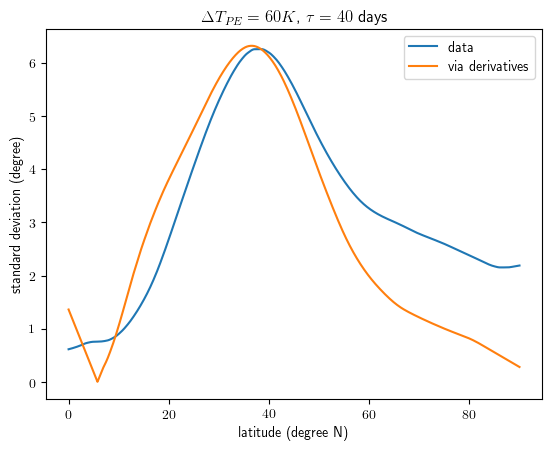

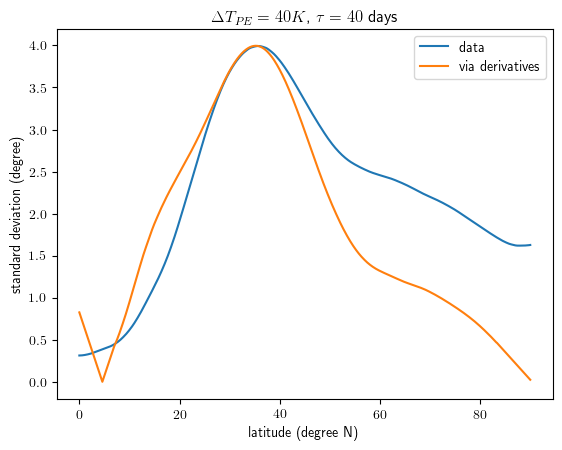

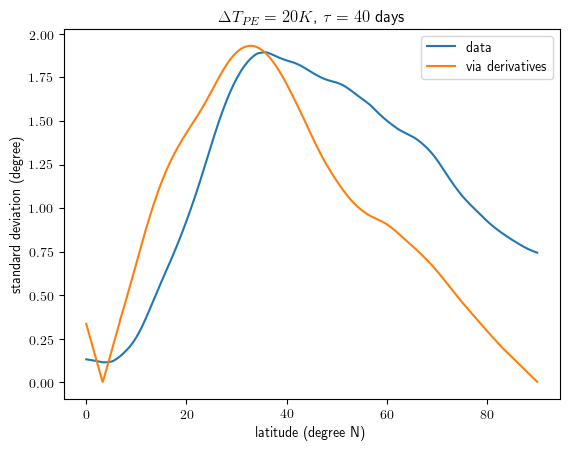

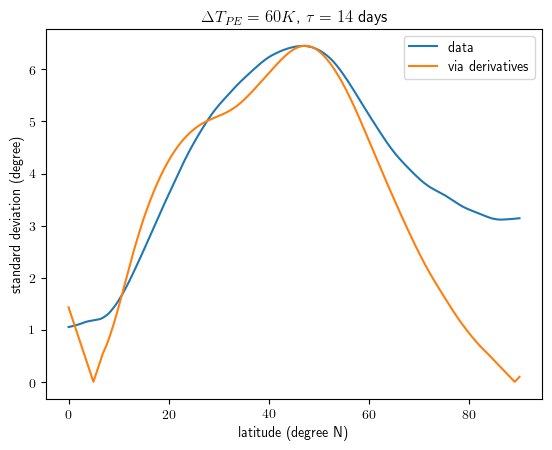

In [30]:
titles = [r'$\Delta T_{PE} = 60K$, $\tau = 40$ days', r'$\Delta T_{PE} = 40K$, $\tau = 40$ days', r'$\Delta T_{PE} = 20K$, $\tau = 40$ days', r'$\Delta T_{PE} = 60K$, $\tau = 14$ days']
for i in range(0, len(titles)):
    plt.figure()
    plt.plot(Phi_half, sigma_T[i], label = 'data')
    plt.plot(Phi_half, sigma_T_deriv[i], label = 'via derivatives')
    plt.xlabel('latitude (degree N)')
    plt.ylabel('standard deviation (degree)')
    plt.title(titles[i])
    plt.legend()
    plt.show()

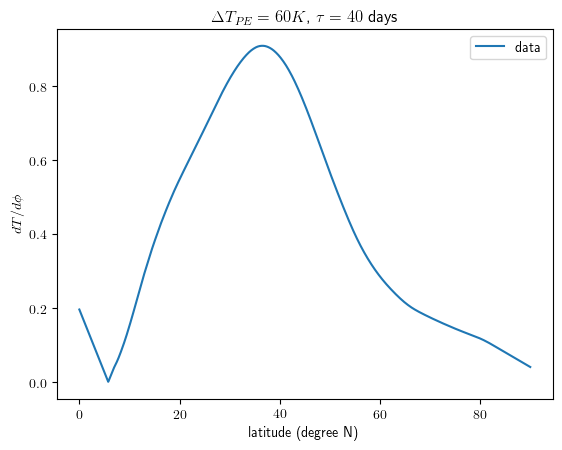

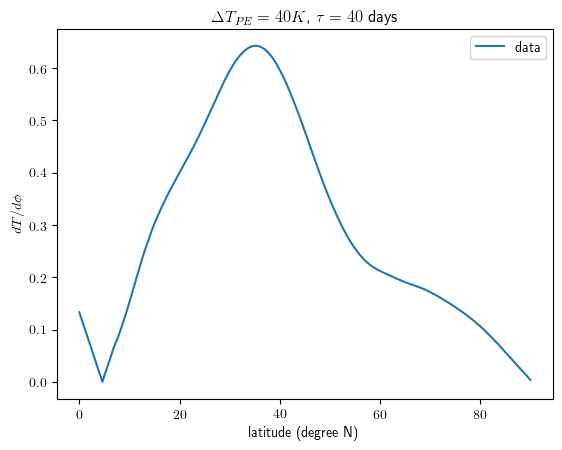

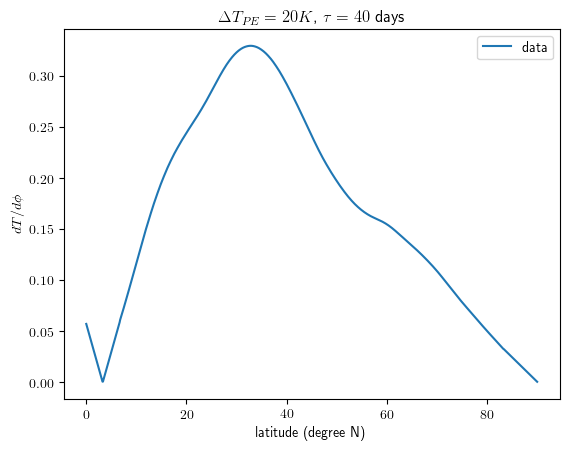

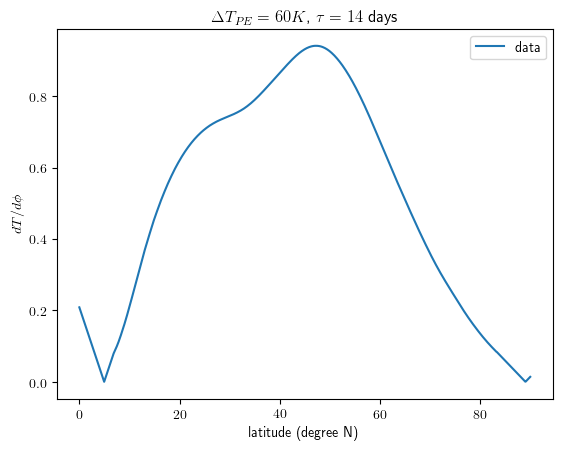

In [31]:
for i in range(0, len(titles)):
    plt.figure()
    plt.plot(Phi_half, np.abs(dTdphi[i]), label = 'data')
    plt.xlabel('latitude (degree N)')
    plt.ylabel(r'$dT/d\phi$')
    plt.title(titles[i])
    plt.legend()
    plt.show()

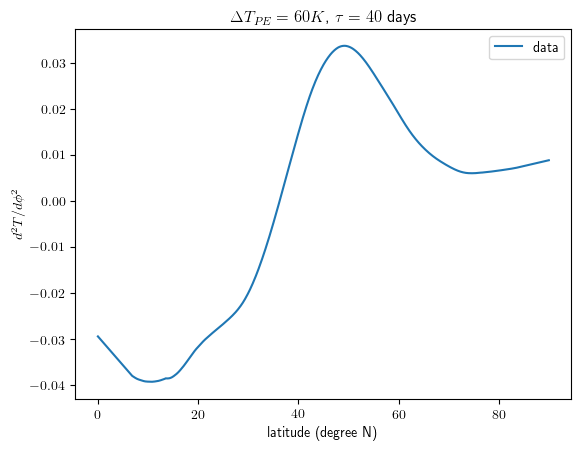

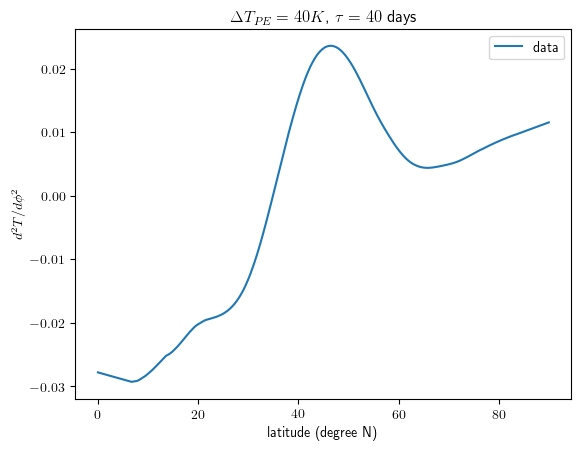

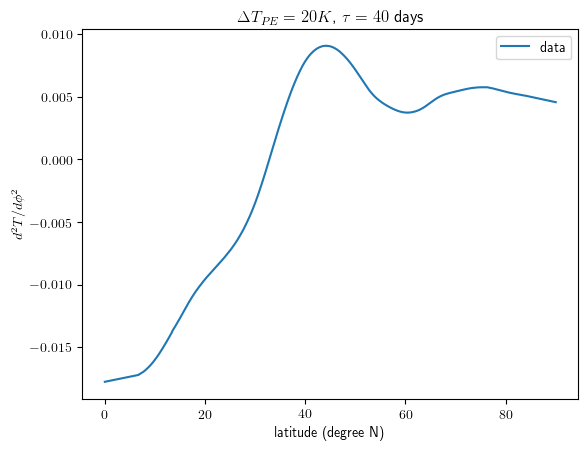

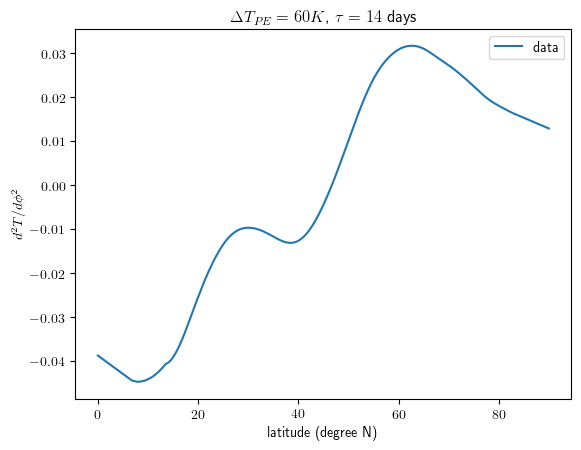

In [32]:
for i in range(0, len(titles)):
    plt.figure()
    plt.plot(Phi_half, d2Tdphi2[i], label = 'data')
    plt.xlabel('latitude (degree N)')
    plt.ylabel(r'$d^2T/d\phi^2$')
    plt.title(titles[i])
    plt.legend()
    plt.show()

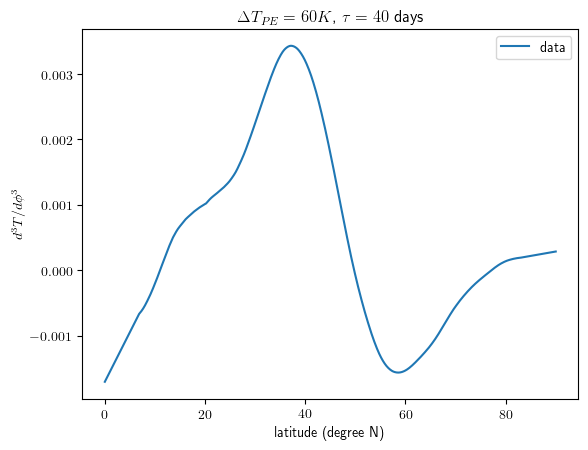

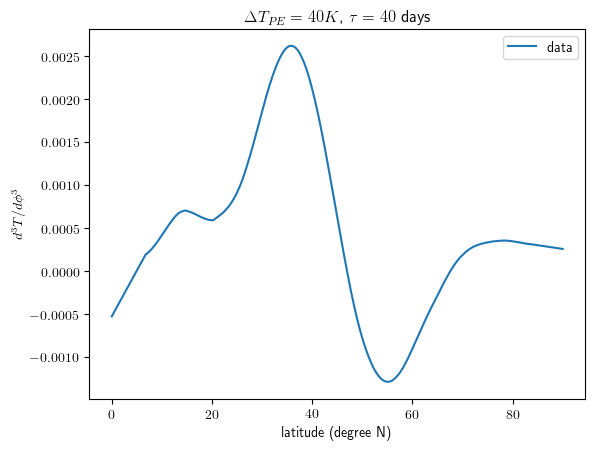

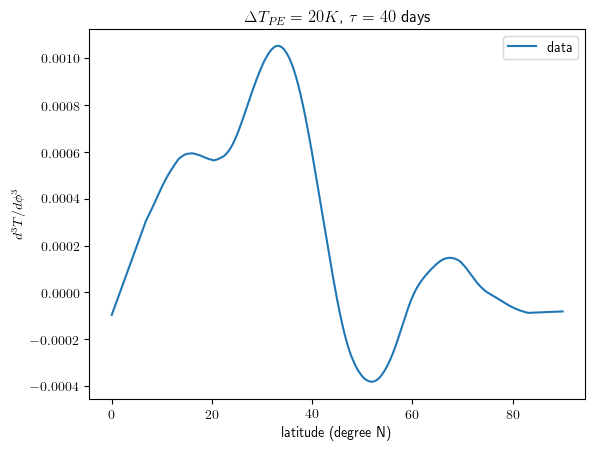

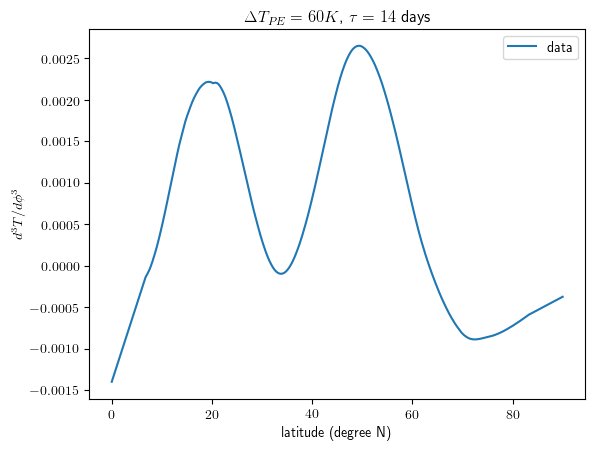

In [33]:
for i in range(0, len(titles)):
    plt.figure()
    plt.plot(Phi_half, d3Tdphi3[i], label = 'data')
    plt.xlabel('latitude (degree N)')
    plt.ylabel(r'$d^3T/d\phi^3$')
    plt.title(titles[i])
    plt.legend()
    plt.show()

In [34]:
#Want ratio as well
d2_over_d1 = []
d3_over_d1 = []
for i in range(0,len(titles)):
    d2_over_d1_mid = []
    d3_over_d1_mid = []
    for j in range(0,len(dTdphi[0])):
        ratio1 = d2Tdphi2[i][j]/np.abs(dTdphi[i][j])
        ratio2 = d3Tdphi3[i][j]/np.abs(dTdphi[i][j])
        d2_over_d1_mid.append(ratio1)
        d3_over_d1_mid.append(ratio2)
    d2_over_d1.append(d2_over_d1_mid)
    d3_over_d1.append(d3_over_d1_mid)

In [35]:
#Bounds for plotting
lb = 250
ub = 800

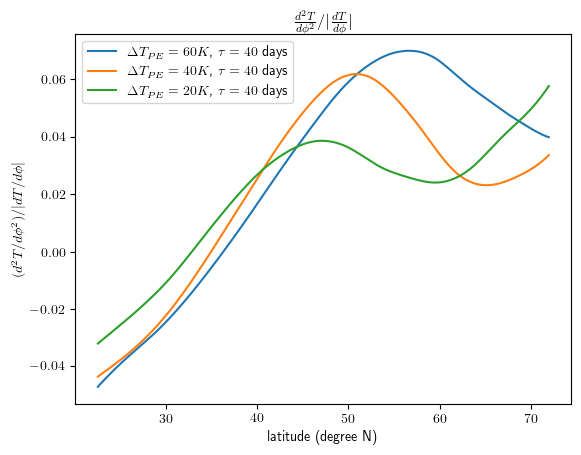

In [36]:
plt.figure()
for i in range(0, len(titles)-1):
    plt.plot(Phi_half[lb:ub], d2_over_d1[i][lb:ub],label=titles[i])
plt.xlabel('latitude (degree N)')
plt.ylabel(r'$(d^2T/d\phi^2)/|dT/d\phi|$')
plt.title(r'$\frac{d^2T}{d\phi^2}/|\frac{dT}{d\phi}|$')
plt.legend()
plt.show()

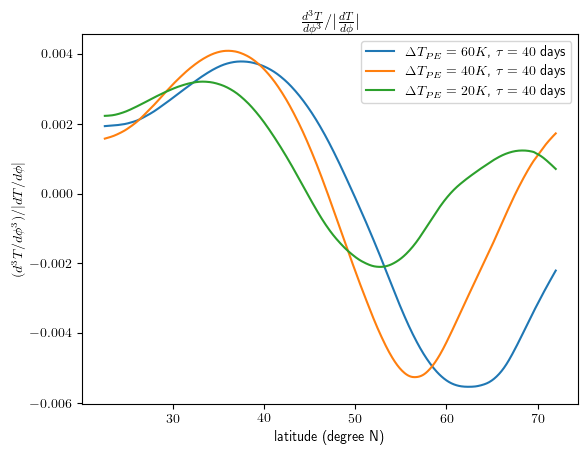

In [37]:
plt.figure()
for i in range(0, len(titles)-1):
    plt.plot(Phi_half[lb:ub], d3_over_d1[i][lb:ub],label=titles[i])
plt.xlabel('latitude (degree N)')
plt.ylabel(r'$(d^3T/d\phi^3)/|dT/d\phi|$')
plt.title(r'$\frac{d^3T}{d\phi^3}/|\frac{dT}{d\phi}|$')
plt.legend()
plt.show()

In [38]:
####### FUNCTION Calculate skew from data #######
def calculate_skew_data(lon_i, number):
    mu_original = []
    for i in range(0,len(lat_half)):
        if lon_index == 1000:
            T_vs_lat = T_lon_ave[number].isel(lat = i+start_i)
        else:
            T_vs_lat = T_original[number].isel(pfull = pp_index, lon = lon_index, lat = i+start_i)

        skew =scipy.stats.skew(T_vs_lat)
        mu_original.append(skew)
    
    mu = scipy.interpolate.pchip_interpolate(lat_half, mu_original, Phi_half)
    return mu

In [39]:
###FUNCTION calculate skew from derivatives###
def calculate_skew_deriv(number, sigma_phi, sigma_T):
    skew = []
    for i in range(0,len(Phi_half)):
        #direct_version
        #mu = 3*dTdphi[number][i]**2*d2Tdphi2[number][i]*sigma_phi**4
        #skew.append(mu/sigma_T[i]**3)
        
        #partway derivative version 
        mu = 3*d2Tdphi2[number][i]*sigma_phi**2
        skew.append(mu/sigma_T[i])
        
        #all the way derivative
        #mu = 3*d2Tdphi2[number][i]*sigma_phi/np.abs(dTdphi[number][i])
        #skew.append(mu)
        
        
    return skew

In [40]:
#mu0, mu1, mu2, mu3 = calculate_skew_deriv(sigma_phi_data6040, std6040_data, delta_T_minus, 0)
mu_deriv6040 = calculate_skew_deriv(0, sigma_phi[0], sigma_T[0])
mu6040 = calculate_skew_data(lon_index,0)
mu_deriv4040 = calculate_skew_deriv(1, sigma_phi[1], std4040_data)
mu4040 = calculate_skew_data(lon_index,1)
mu_deriv2040 = calculate_skew_deriv(2, sigma_phi[2], std2040_data)
mu2040 = calculate_skew_data(lon_index,2)
mu_deriv6014 = calculate_skew_deriv(3, sigma_phi[3], std6014_data)
mu6014 = calculate_skew_data(lon_index,3)
mu_deriv = [mu_deriv6040, mu_deriv4040, mu_deriv2040, mu_deriv6014]
mu = [mu6040,mu4040,mu2040,mu6014]

In [41]:
#same with fake values mu_deriv6040 = calculate_skew_deriv(0, sigma_phi[0], sigma_T[0])
# mu_deriv6040 = calculate_skew_deriv(0, sigma_phi[0], sigma_T[0])
# mu6040 = calculate_skew_data(lon_index,0)
# mu_deriv4040 = calculate_skew_deriv(1, sigma_phi[0], std4040_data)
# mu4040 = calculate_skew_data(lon_index,1)
# mu_deriv2040 = calculate_skew_deriv(2, sigma_phi[0], std2040_data)
# mu2040 = calculate_skew_data(lon_index,2)
# mu_deriv6014 = calculate_skew_deriv(3, sigma_phi[0], std6014_data)
# mu6014 = calculate_skew_data(lon_index,3)
# mu_deriv = [mu_deriv6040, mu_deriv4040, mu_deriv2040, mu_deriv6014]
# mu = [mu6040,mu4040,mu2040,mu6014]

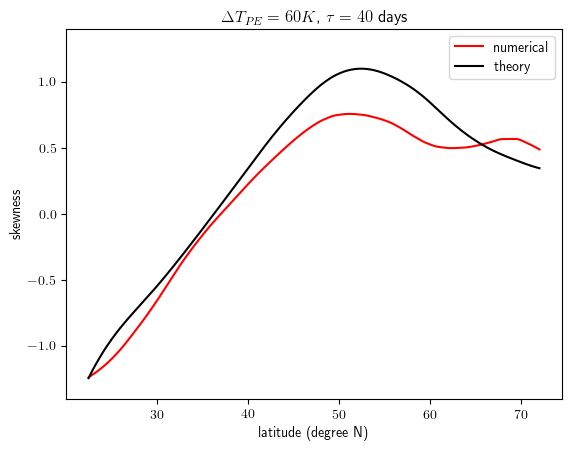

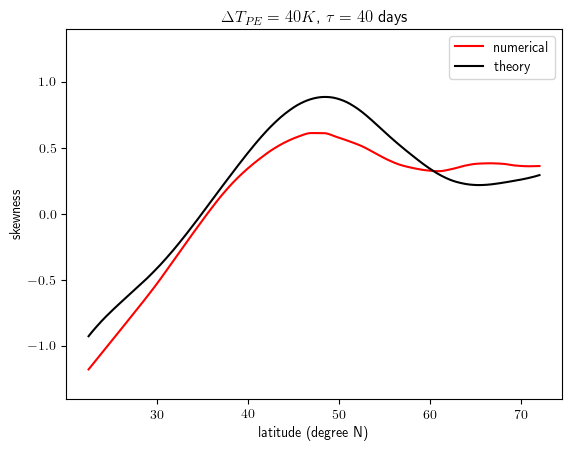

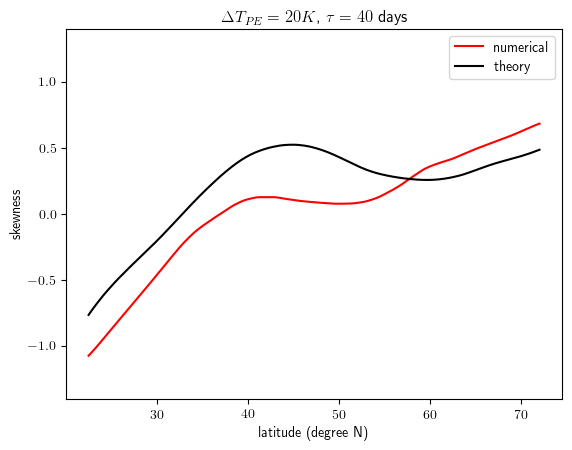

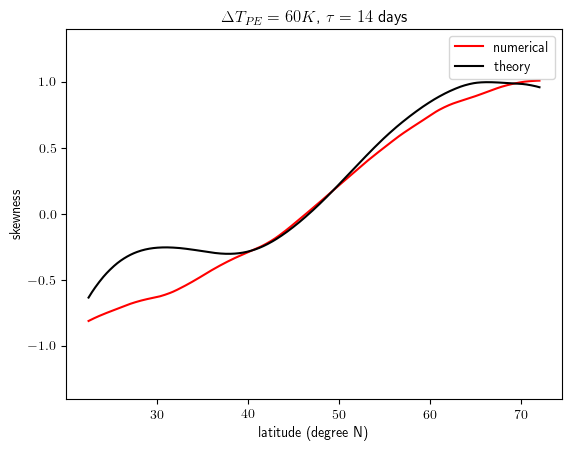

In [68]:
#Skew plots
conditions = ['6040', '4040', '2040', '6014']
for j in range(0,len(mu)):
    plt.figure()
    plt.plot(Phi_half[lb:ub], mu[j][lb:ub], label = 'numerical', color = 'red')
    plt.plot(Phi_half[lb:ub], mu_deriv[j][lb:ub],label = 'theory', color = 'black')
    plt.ylim(-1.4, 1.4)
    plt.xlabel('latitude (degree N)')
    plt.ylabel('skewness')
    plt.title(titles[j])
    plt.legend()
    plt.savefig('figures/skewness' + conditions[j]+'.png')

In [43]:
(max(mu[0][lb:ub])-max(mu[1][lb:ub]))/max(mu[0][lb:ub])

0.19181863873476687

In [44]:
(max(d2_over_d1[0][lb:ub])-max(d2_over_d1[1][lb:ub]))/max(d2_over_d1[0][lb:ub])

0.11599288207226507

In [45]:
(sigma_phi[0]-sigma_phi[1])/sigma_phi[0]

0.10545466905966659

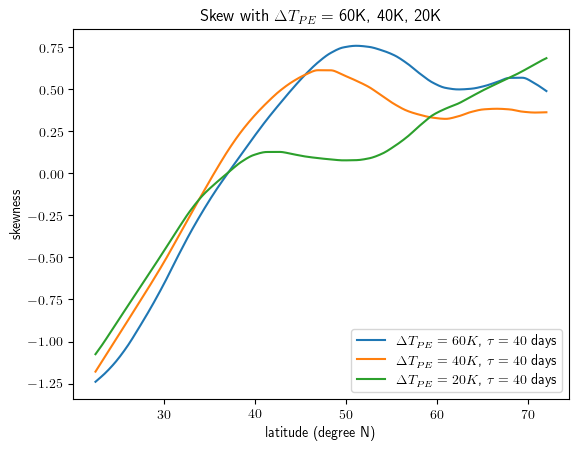

In [46]:
plt.figure()
for i in range(0, len(titles)-1):
    plt.plot(Phi_half[lb:ub], mu[i][lb:ub],label=titles[i])
plt.xlabel('latitude (degree N)')
plt.ylabel('skewness')
plt.title(r'Skew with $\Delta T_{PE} =$ 60K, 40K, 20K')
plt.legend()
plt.show()

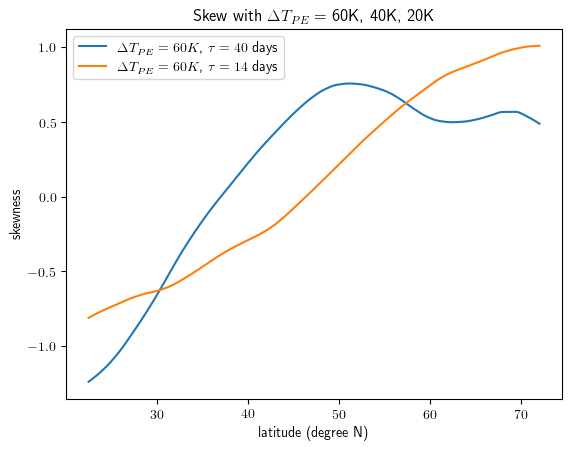

In [47]:
plt.figure()
plt.plot(Phi_half[lb:ub], mu[0][lb:ub],label=titles[0])
plt.plot(Phi_half[lb:ub], mu[3][lb:ub],label=titles[3])
plt.xlabel('latitude (degree N)')
plt.ylabel('skewness')
plt.title(r'Skew with $\Delta T_{PE} =$ 60K, 40K, 20K')
plt.legend()
plt.show()

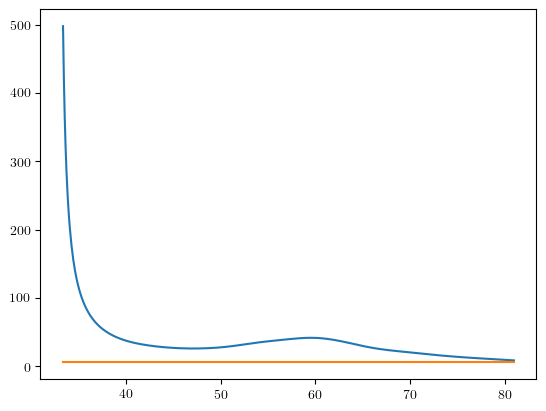

In [48]:
#Compare sigma and dTdphi/d^2Tdphi^2
lb = 370
ub = 900
ratio = []
sigma_graph = sigma_phi[2]*np.ones(len(dTdphi[2]))
for i in range(0,len(dTdphi[2])):
    value = np.abs(dTdphi[2][i]/d2Tdphi2[2][i])
    ratio.append(value)
plt.plot(Phi_half[lb:ub],ratio[lb:ub])
plt.plot(Phi_half[lb:ub],sigma_graph[lb:ub])

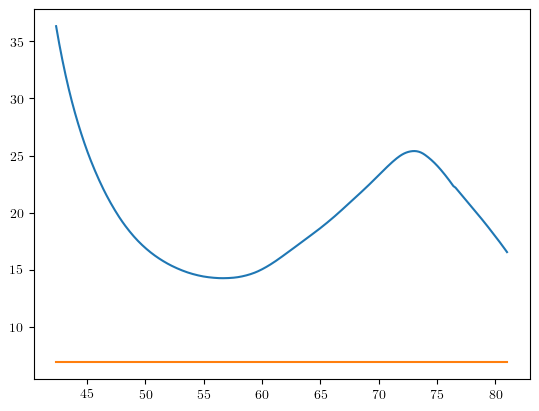

In [49]:
#Compare sigma and dTdphi/d^2Tdphi^2
lb = 470
ub = 900
ratio = []
sigma_graph = sigma_phi[0]*np.ones(len(dTdphi[0]))
for i in range(0,len(dTdphi[0])):
    value = np.abs(dTdphi[0][i]/d2Tdphi2[0][i])
    ratio.append(value)
plt.plot(Phi_half[lb:ub],ratio[lb:ub])
plt.plot(Phi_half[lb:ub],sigma_graph[lb:ub])

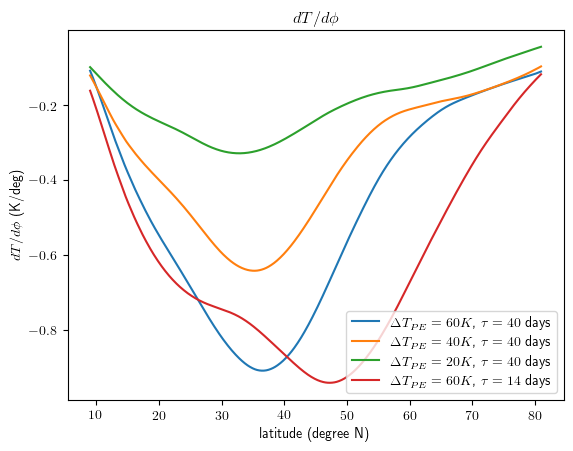

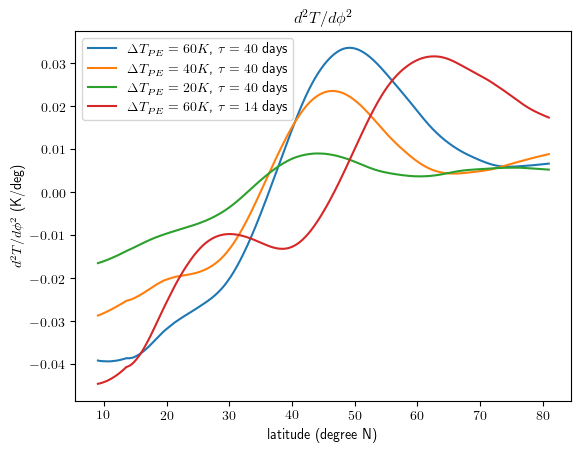

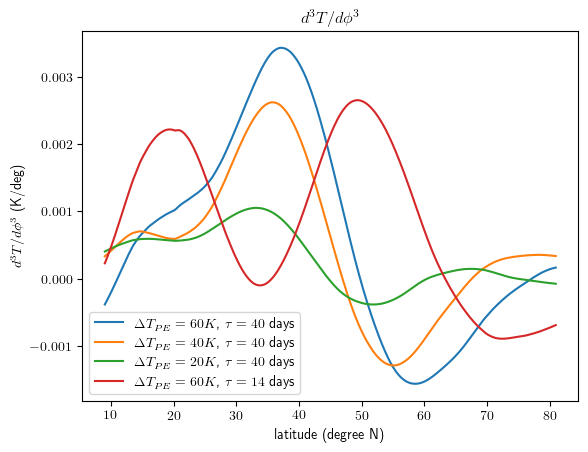

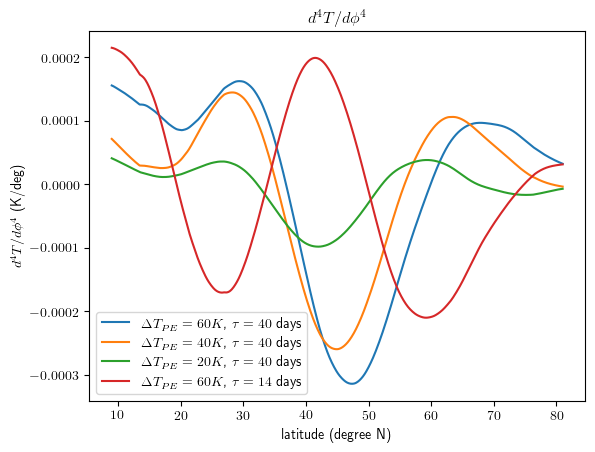

In [50]:
lb = 100
ub = 900
plt.figure()
for i in range(0,len(dTdphi)):
    plt.plot(Phi_half[lb:ub],dTdphi[i][lb:ub], label = titles[i])
    plt.title('$dT/d\phi$')
    plt.xlabel('latitude (degree N)')
    plt.ylabel('$dT/d\phi$ (K/deg)')
plt.legend()
plt.show()
plt.figure()
for i in range(0,len(dTdphi)):
    plt.plot(Phi_half[lb:ub],d2Tdphi2[i][lb:ub], label = titles[i])
    plt.title('$d^2T/d\phi^2$')
    plt.xlabel('latitude (degree N)')
    plt.ylabel('$d^2T/d\phi^2$ (K/deg)')
plt.legend()
plt.show()
for i in range(0,len(dTdphi)):
    plt.plot(Phi_half[lb:ub],d3Tdphi3[i][lb:ub], label = titles[i])
    plt.title('$d^3T/d\phi^3$')
    plt.xlabel('latitude (degree N)')
    plt.ylabel('$d^3T/d\phi^3$ (K/deg)')
plt.legend()
plt.show()
for i in range(0,len(dTdphi)):
    plt.plot(Phi_half[lb:ub],d4Tdphi4[i][lb:ub], label = titles[i])
    plt.title('$d^4T/d\phi^4$')
    plt.xlabel('latitude (degree N)')
    plt.ylabel('$d^4T/d\phi^4$ (K/deg)')
plt.legend()
plt.show()

## Compare tau dT/dt

In [51]:
#Pick a location
latitude = 60
longitude = 20
plevel = 850
lat_index, lat_value, pp_index, pp_value, lon_index, lon_value = pick_location(latitude, longitude, plevel)
print(pp_index)
print(lat_index)
print(lon_index)
#latitude 30 index = 85
#latitude 60 index = 106

23
106
14


In [52]:
def compute_averagetaudTdt(array, tau):
    dTdt_set = []
    for j in range(85, 107):
        taudTdt6040_array = array.isel(lat = j, lon = lon_index, pfull = pp_index)        
        for i in range(1,len(taudTdt6040_array)):
            value = np.abs(taudTdt6040_array[i].values-taudTdt6040_array[i-1].values)
            dTdt_set.append(value)
    average_value = tau * sum(dTdt_set)/len(dTdt_set)
    print(average_value)

In [53]:
tau = [40,40,40,14]
for i in range(0,4):
    compute_averagetaudTdt(T_original[i],tau[i])
    

115.2069542266381
68.18703074362207
30.717889448088258
59.302467050178635


In [54]:
averagetaudTdt = [115.2069542266381,68.18703074362207,30.717889448088258,59.302467050178635]

## Map of wind on cold/hot day

In [ ]:
day_index = 125
wind_u = ds6040.ucomp.isel(time = day_index, pfull = pp_index)
wind_v = ds6040.vcomp.isel(time = day_index, pfull = pp_index)

In [ ]:
wind_v

In [ ]:
print(len(T6040.lat.values))
print(len(wind_u))
print(len(T6040.lon.values))
print(len(wind_v))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
colorbar_label='colorbar label'
title='title'
color_map=plt.get_cmap('RdBu').reversed()
#H2023anomaly1.plot(ax=ax,transform=ccrs.PlateCarree(),
                       #cmap=color_map,
                       #cbar_kwargs={'label':colorbar_label})
q = ax.quiver(T6040.lat.values, T6040.lon.values,wind_u,wind_v)        
ax.gridlines()
ax.coastlines()
ax.set_title(title)

In [ ]:
ds6040.load()

## Check v and sigma_v

In [ ]:
v6040_mean = ds6040.vcomp.sel(time = slice('1812-04','1826')).isel(pfull = pp_index, lon = lon_index).mean(dim = 'time')
v4040_mean = ds4040.vcomp.sel(time = slice('1812-04','1826')).isel(pfull = pp_index, lon = lon_index).mean(dim = 'time')
v2040_mean = ds2040.vcomp.sel(time = slice('1812-04','1826')).isel(pfull = pp_index, lon = lon_index).mean(dim = 'time')
v6014_mean = ds6014.vcomp.sel(time = slice('1812-04','1826')).isel(pfull = pp_index, lon = lon_index).mean(dim = 'time')

In [ ]:
v6040 = ds6040.vcomp.sel(time = slice('1812-04','1826')).isel(pfull = pp_index, lon = lon_index)
v4040 = ds4040.vcomp.sel(time = slice('1812-04','1826')).isel(pfull = pp_index, lon = lon_index)
v2040 = ds2040.vcomp.sel(time = slice('1812-04','1826')).isel(pfull = pp_index, lon = lon_index)
v6014 = ds6014.vcomp.sel(time = slice('1812-04','1826')).isel(pfull = pp_index, lon = lon_index)

In [ ]:
v_mean = [v6040_mean,v4040_mean,v2040_mean,v6014_mean]
v = [v6040,v4040,v2040,v6014]

In [ ]:
lbv = 13
ubv = 59
for j in range(0,len(v)):
    plt.figure()
    plt.plot(lat_half[lbv:ubv], v_mean[j][64+lbv:64+ubv])
    plt.xlabel('latitude (degree N)')
    plt.ylabel('meridional velocity (m/s)')
    plt.title(titles[j])
    plt.legend()

In [ ]:
v_abs = []
for j in range(0,len(v)):
    speed =[]
    for i in v_mean[j]:
        speed.append(np.abs(i))
    v_abs.append(speed)

In [ ]:
for j in range(0,len(v)):
    plt.figure()
    plt.plot(lat_half[lbv:ubv], v_abs[j][64+lbv:64+ubv])
    plt.xlabel('latitude (degree N)')
    plt.ylabel('meridional velocity (m/s)')
    plt.title(titles[j])
    plt.legend()

In [55]:
#####Calculate kurtosis from data
def calculate_kurtosis_data(lon_i, number):
    kurt_original = []
    for i in range(0,len(lat_half)):
        if lon_index == 1000:
            T_vs_lat = T_lon_ave[number].isel(lat = i+start_i)
        else:
            T_vs_lat = T_original[number].isel(pfull = pp_index, lon = lon_index, lat = i+start_i)

        kurt =scipy.stats.kurtosis(T_vs_lat, fisher = False)
        kurt_original.append(kurt)
    
    kurtosis = scipy.interpolate.pchip_interpolate(lat_half, kurt_original, Phi_half)
    return kurtosis

In [56]:
###FUNCTION calculate kurtosis from derivatives###
def calculate_kurtosis_deriv(number, sigma_phi, sigma_T):
    kurtosis = []
    for i in range(0,len(Phi_half)):
        #one term
        #kurt = 3*dTdphi[number][i]**4*sigma_phi**4
        #kurtosis.append(kurt/sigma_T[i]**4)
        
        #one term partially derivative
        #kurtosis.append(3)
        
        #two terms
        #kurt = 3*dTdphi[number][i]**4*sigma_phi**4 + 5*dTdphi[number][i]**2*(3*d2Tdphi2[number][i]**2+2*dTdphi[number][i]*d3Tdphi3[number][i])*sigma_phi**6
        #kurtosis.append(kurt/sigma_T[i]**4)
        
        #two terms, partway dervative
        #kurt = 3 + 5*(3*dTdphi[number][i]**2+2*d2Tdphi2[number][i]*d3Tdphi3[number][i])*sigma_phi**4/(sigma_T[i]**2)
        #kurtosis.append(kurt)

        #two terms, even more part way with derivative
        kurt = 3 + dTdphi[number][i]**2*(15*d2Tdphi2[number][i]**2+4*dTdphi[number][i]*d3Tdphi3[number][i])*sigma_phi**6/sigma_T[i]**4
        kurtosis.append(kurt)

    return kurtosis

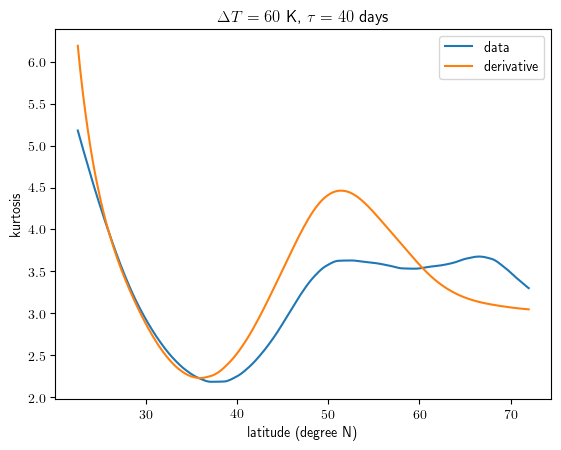

In [57]:
lb = 250
ub = 800
kurtosis_data = calculate_kurtosis_data(140, 0)
kurtosis_deriv = calculate_kurtosis_deriv(0,sigma_phi[0],sigma_T[0])
plt.plot(Phi_half[lb:ub],kurtosis_data[lb:ub], label = 'data')
plt.plot(Phi_half[lb:ub],kurtosis_deriv[lb:ub], label = 'derivative')
plt.title(r'$\Delta T = 60$ K, $\tau = 40$ days')
plt.xlabel('latitude (degree N)')
plt.ylabel('kurtosis')
plt.legend()

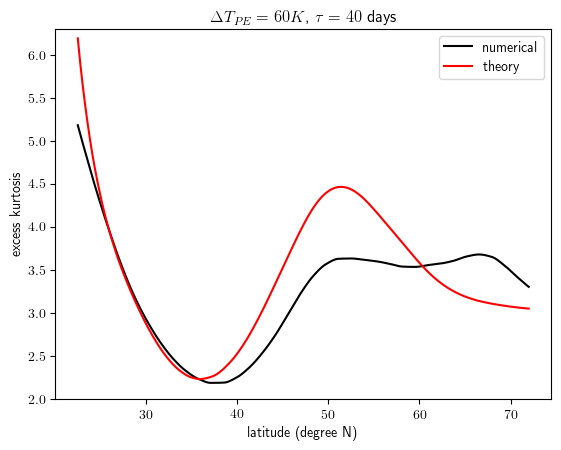

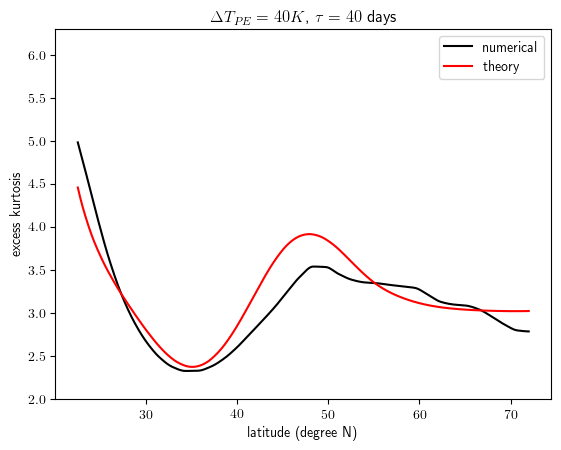

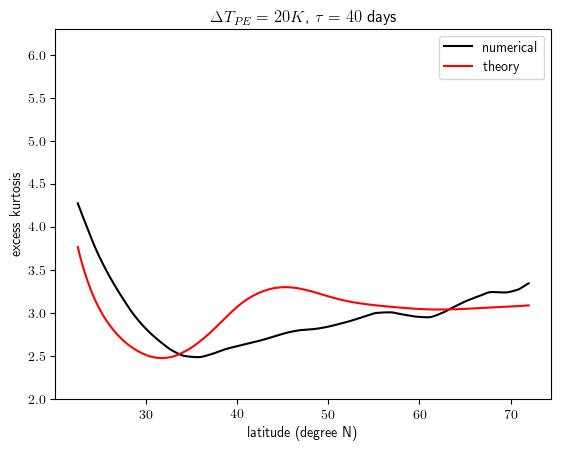

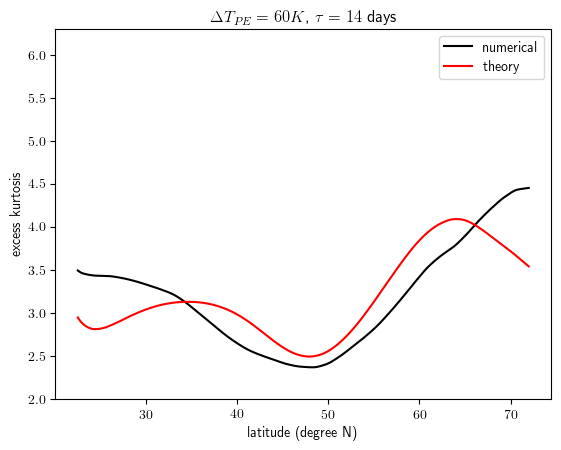

In [70]:
#True plots
lb = 250
ub = 800
for i in range(0,len(sigma_T)):
    kurtosis_data = calculate_kurtosis_data(lon_index, i)
    kurtosis_deriv = calculate_kurtosis_deriv(i,sigma_phi[i],sigma_T[i])
    plt.figure()
    plt.plot(Phi_half[lb:ub],kurtosis_data[lb:ub], label = 'numerical', color = 'black')
    plt.plot(Phi_half[lb:ub],kurtosis_deriv[lb:ub], label = 'theory', color = 'red')
    plt.title(titles[i])
    plt.ylim(2,6.3)
    plt.xlabel('latitude (degree N)')
    plt.ylabel('excess kurtosis')
    plt.legend()
    #plt.show()
    plt.savefig('figures/kurtosis' + conditions[i]+'.png')

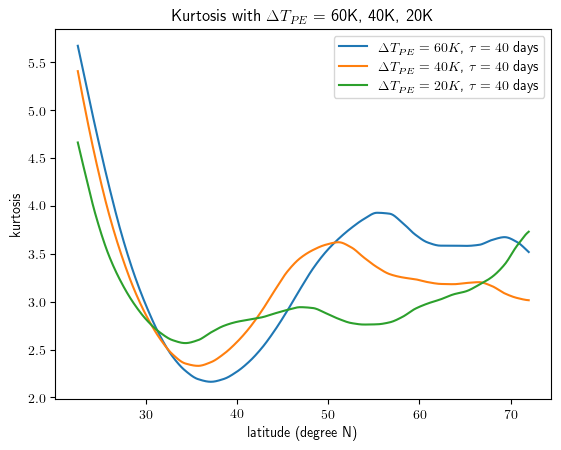

In [40]:
plt.figure()
for i in range(0, len(titles)-1):
    kurtosis_data = calculate_kurtosis_data(lon_index, i)
    plt.plot(Phi_half[lb:ub], kurtosis_data[lb:ub],label=titles[i])
plt.xlabel('latitude (degree N)')
plt.ylabel('kurtosis')
plt.title('Kurtosis with $\Delta T_{PE} =$ 60K, 40K, 20K')
plt.legend()
plt.show()

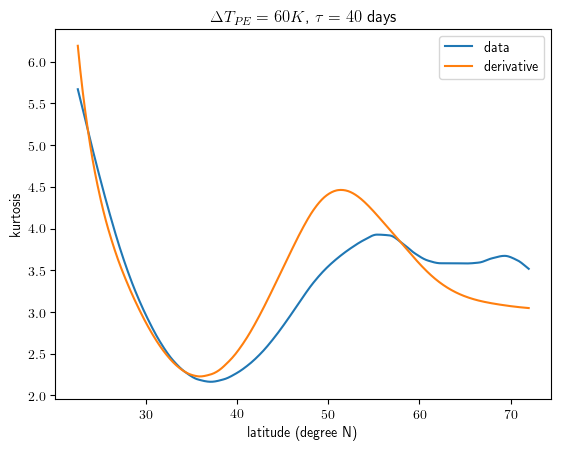

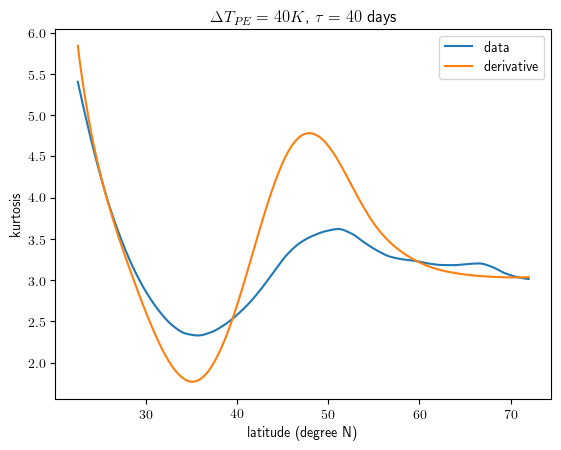

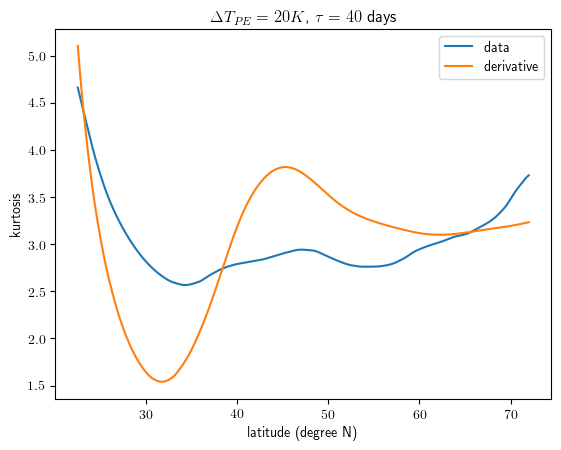

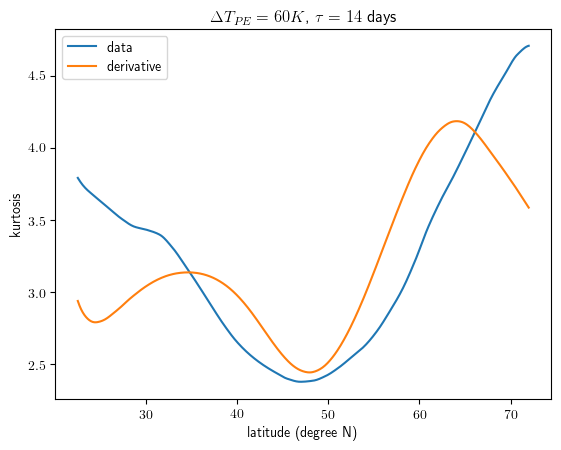

In [52]:
#Same as above but fake sigma
lb = 250
ub = 800
for i in range(0,len(sigma_T)):
    kurtosis_data = calculate_kurtosis_data(140, i)
    kurtosis_deriv = calculate_kurtosis_deriv(i,sigma_phi[0],sigma_T[i])
    plt.figure()
    plt.plot(Phi_half[lb:ub],kurtosis_data[lb:ub], label = 'data')
    plt.plot(Phi_half[lb:ub],kurtosis_deriv[lb:ub], label = 'derivative')
    plt.title(titles[i])
    plt.xlabel('latitude (degree N)')
    plt.ylabel('kurtosis')
    plt.legend()
    plt.show()


In [ ]:
#Calculate sigma_v
#sigma_v = []
#for j in range(0,len(v)):
#    sigmav = []
#    for i in range(start_i,end_i):
#        sigma = scipy.stats.tstd(v[j].isel(lat = i))
#        sigmav.append(sigma)
#    sigma_v.append(sigmav)

In [ ]:
for j in range(0,len(v)):
    plt.figure()
    plt.plot(lat_half[lbv:ubv], sigma_v[j][lbv:ubv])
    plt.xlabel('latitude (degree N)')
    plt.ylabel('meridional velocity (m/s)')
    plt.title(titles[j])
    plt.legend()

## Run all the above with various longitudes, for the average!

In [ ]:
###FUNCTION###
def run_everything(lon_index):
    #Decide the location
    pp_index= 23
    #lat_index, latitude, pp_index, pp, lon_index, longitude = pick_location(67,lon,pressure)
    if lon_index == 1000:
        pass
    else:
        T_ave_profile6040 = T_ave6040.isel(lon = lon_index, pfull = pp_index).values
        T_ave_profile4040 = T_ave4040.isel(lon = lon_index, pfull = pp_index).values
        T_ave_profile2040 = T_ave2040.isel(lon = lon_index, pfull = pp_index).values
        T_ave_profile6014 = T_ave6014.isel(lon = lon_index, pfull = pp_index).values

    T_lon_ave6040 = T6040.isel(pfull = pp_index).mean(dim = 'lon')
    T_lon_time_ave6040 = T_lon_ave6040.mean(dim = 'time').values
    T_lon_ave4040 = T4040.isel(pfull = pp_index).mean(dim = 'lon')
    T_lon_time_ave4040 = T_lon_ave4040.mean(dim = 'time').values
    T_lon_ave2040 = T2040.isel(pfull = pp_index).mean(dim = 'lon')
    T_lon_time_ave2040 = T_lon_ave2040.mean(dim = 'time').values
    T_lon_ave6014 = T6014.isel(pfull = pp_index).mean(dim = 'lon')
    T_lon_time_ave6014 = T_lon_ave6014.mean(dim = 'time').values

    #Put the data in an array for convenience (decreasing order in temperature, then change in tau)
    #number index: 0 = 6040, 1 = 4040, 2 = 2040, 3 = 6014
    T_lon_ave = [T_lon_ave6040, T_lon_ave4040, T_lon_ave2040, T_lon_ave6014] #Lon average, pfull is set. Has data for different times
    T_ave_profile = [T_ave_profile6040, T_ave_profile4040, T_ave_profile2040, T_ave_profile6014] #Time average, lon and pfull are set
    T_lon_time_ave = [T_lon_time_ave6040, T_lon_time_ave4040, T_lon_time_ave2040, T_lon_time_ave6014] #Lon and time average, pfull is set
    T_original = [T6040, T4040, T2040, T6014] #Original T - not even pful is set
    
    ##Derivatives

    #Phi and original T
    Phi_half = np.linspace(0,90,1000)

    #Interpolate T
    T_profile = []
    for i in range(0, len(T_lon_ave)):
        if lon_index == 1000:
            T_interpolate = scipy.interpolate.pchip_interpolate(T6040.lat.values, T_lon_time_ave[i], Phi_half)
        else:
            T_interpolate = scipy.interpolate.pchip_interpolate(T6040.lat.values, T_ave_profile[i], Phi_half)
        T_profile.append(T_interpolate)

    #Calculate derivatives 
    dTdphi = []
    d2Tdphi2 = []
    d3Tdphi3 = []
    d4Tdphi4 = []
    d5Tdphi5 = []
    d6Tdphi6 = []
    for i in range(0, len(T_lon_ave)):
        dTdphi1 = take_derivative(Phi_half, T_profile[i])
        dTdphi1 = scipy.signal.savgol_filter(dTdphi1,51,3)
        dTdphi.append(dTdphi1)
        dTdphi2 = take_derivative(Phi_half, dTdphi1)
        dTdphi2 = scipy.signal.savgol_filter(dTdphi2,51,3)
        d2Tdphi2.append(dTdphi2)
        dTdphi3 = take_derivative(Phi_half, dTdphi2)
        dTdphi3 = scipy.signal.savgol_filter(dTdphi3,100,3)
        d3Tdphi3.append(dTdphi3)
        dTdphi4 = take_derivative(Phi_half, dTdphi3)
        dTdphi4 = scipy.signal.savgol_filter(dTdphi4,100,3)
        d4Tdphi4.append(dTdphi4)
        dTdphi5 = take_derivative(Phi_half, dTdphi4)
        dTdphi5 = scipy.signal.savgol_filter(dTdphi5,100,3)
        d5Tdphi5.append(dTdphi5)
        dTdphi6 = take_derivative(Phi_half, dTdphi5)
        dTdphi6 = scipy.signal.savgol_filter(dTdphi6,100,3)
        d6Tdphi6.append(dTdphi6)
        
    #Calculate sigma T here
    std4040_data = calculate_sigma_T_data(1)
    std6040_data = calculate_sigma_T_data(0)
    std2040_data = calculate_sigma_T_data(2)
    std6014_data = calculate_sigma_T_data(3)
    sigma_T = [std6040_data, std4040_data, std2040_data, std6014_data]

    #Make a function that gives my estimate from derivatives

    #Find the max location first 
    epsilon = 10
    sigma_phi = []
    for j in range(0, len(T_lon_ave)):
        index = np.where(sigma_T[j] == max(sigma_T[j]))[0][0]
        domain1 = index-epsilon
        domain2 = index+epsilon
        def f_sigma(phi, sigma):
            std1 = []
        #    for i in range(0,len(Phi_half)):
            for i in range(domain1,domain2):
                variance = dTdphi[j][i]**2 * sigma **2
                std1.append(np.sqrt(variance))
            return std1

        #Fit!
        fit_values, sigma_cov = scipy.optimize.curve_fit(f_sigma, Phi_half[domain1:domain2], sigma_T[j][domain1:domain2])
        sigma_phi.append(fit_values[0])

    #STD calculated through derivatives
    sigma_T_deriv = []
    for i in range(0, len(T_lon_ave)):
        sigmaT = np.sqrt(dTdphi[i]**2*sigma_phi[i]**2)
        sigma_T_deriv.append(sigmaT)

    #mu0, mu1, mu2, mu3 = calculate_skew_deriv(sigma_phi_data6040, std6040_data, delta_T_minus, 0)
    mu_deriv6040 = calculate_skew_deriv(0, sigma_phi[0], sigma_T[0])
    mu6040 = calculate_skew_data(lon_index,0)
    mu_deriv4040 = calculate_skew_deriv(1, sigma_phi[1], std4040_data)
    mu4040 = calculate_skew_data(lon_index,1)
    mu_deriv2040 = calculate_skew_deriv(2, sigma_phi[2], std2040_data)
    mu2040 = calculate_skew_data(lon_index,2)
    mu_deriv6014 = calculate_skew_deriv(3, sigma_phi[3], std6014_data)
    mu6014 = calculate_skew_data(lon_index,3)
    mu_deriv = [mu_deriv6040, mu_deriv4040, mu_deriv2040, mu_deriv6014]
    mu = [mu6040,mu4040,mu2040,mu6014]
    
    print('lon_index = ' + str(lon_index))
    
    return mu, mu_deriv

In [ ]:
skew_data = []
skew_deriv = []
for k in range(0,len(T6040.lon.values)):
    mu_data, mu_deriv = run_everything(k)
    skew_data.append(mu_data)
    skew_deriv.append(mu_deriv)

In [ ]:
#Take an average
skew_data_ave = []
skew_deriv_ave = []
datatype = 2
for j in range(0,len(skew_data[0][0])): #for every latitude
    array_data = []
    array_deriv = []
    for k in range(0,len(skew_data)): #Go through all longitudes
        array_data.append(skew_data[k][datatype][j])
        array_deriv.append(skew_deriv[k][datatype][j])
    the_value_data = statistics.mean(array_data)
    the_value_deriv = statistics.mean(array_deriv)
    skew_data_ave.append(the_value_data)
    skew_deriv_ave.append(the_value_deriv)
    #for i in range(0,len(skew_data[0])):#for every type         

In [ ]:
plt.plot(Phi_half[lb:ub], skew_data_ave[lb:ub])
plt.plot(Phi_half[lb:ub], skew_deriv_ave[lb:ub])

In [ ]:
lb = 200
ub = 900
longitude = 70
for j in range(0,len(skew_data[longitude])):
    plt.figure()
    plt.plot(Phi_half[lb:ub], skew_data[longitude][j][lb:ub], label = 'from data')
    plt.plot(Phi_half[lb:ub], skew_deriv[longitude][j][lb:ub],label = 'derivative')
    plt.xlabel('latitude (degree N)')
    plt.ylabel('skew')
    plt.title(titles[j])
    plt.legend()

In [ ]:
len(skew_data[0])